In [1]:
#imports
import math
#PyTorch imports
import torch
import torch.nn as nn
from torch.optim import AdamW
import torchvision
import torchvision.transforms as transforms
from torchvision import datasets
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.utils.data import random_split
from torch.utils.data import ConcatDataset

#Import SciPy to load the Flowers-102 dataset from the .mat format
import scipy.io

#Other imports
import numpy as np
import matplotlib.pyplot as plt

#Import time so that we can train the model within the 12 hour time limit
import time

In [2]:
#Define transforms
trainingTransform = transforms.Compose([
    transforms.Resize(224), #Change this value to edit the image size
    transforms.RandomRotation(90), #Rotates each image by a random angle between 0-90 degrees
    transforms.CenterCrop(224), #Must be the same as resize value. This is used to ensure the image is square
    #Default probability for both flips is p=0.5, can be changed if needed
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(0,1) #zerocenter normalization
])

trainingTransformBrightness = transforms.Compose([
    transforms.Resize(224),
    transforms.RandomRotation(90),
    transforms.CenterCrop(224),
    transforms.ColorJitter(contrast=(0.5, 0.9), brightness=0.05),
    transforms.ToTensor(),
    transforms.Normalize(0,1)
])

trainingTransformSaturation = transforms.Compose([
    transforms.Resize(224),
    transforms.RandomRotation(90),
    transforms.CenterCrop(224),
    transforms.ColorJitter(saturation=(0.5, 0.9), hue=0.2),
    transforms.ToTensor(),
    transforms.Normalize(0,1)
])

nonTrainTransform = transforms.Compose([
    #Same as training transform without flipping as required
    #by assessment rules
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(0,1)
])

#Load Flowers-102 dataset and split it into train, validate and test splits
trainingSet = datasets.Flowers102(root="./flowers", split="train", download=True, transform=trainingTransform)
trainingSet2 = datasets.Flowers102(root="./flowers", split="train", download=True)
trainingSetBright, trainingSetSat = random_split(trainingSet2, (510, 510)) #splits the data set into non-overlapping halfs
trainingSetSat.dataset.transform = trainingTransformSaturation
trainingSetBright.dataset.transform = trainingTransformBrightness
trainingSet = ConcatDataset([trainingSet, trainingSetBright, trainingSetBright])

validationSet = datasets.Flowers102(root="./flowers", split="val", download=True, transform=nonTrainTransform)
testingSet = datasets.Flowers102(root="./flowers", split="test", download=True, transform=nonTrainTransform)

In [73]:
#Checking the splits are the correct length
print(len(trainingSet))
print(len(validationSet))
print(len(testingSet))

2040
1020
6149


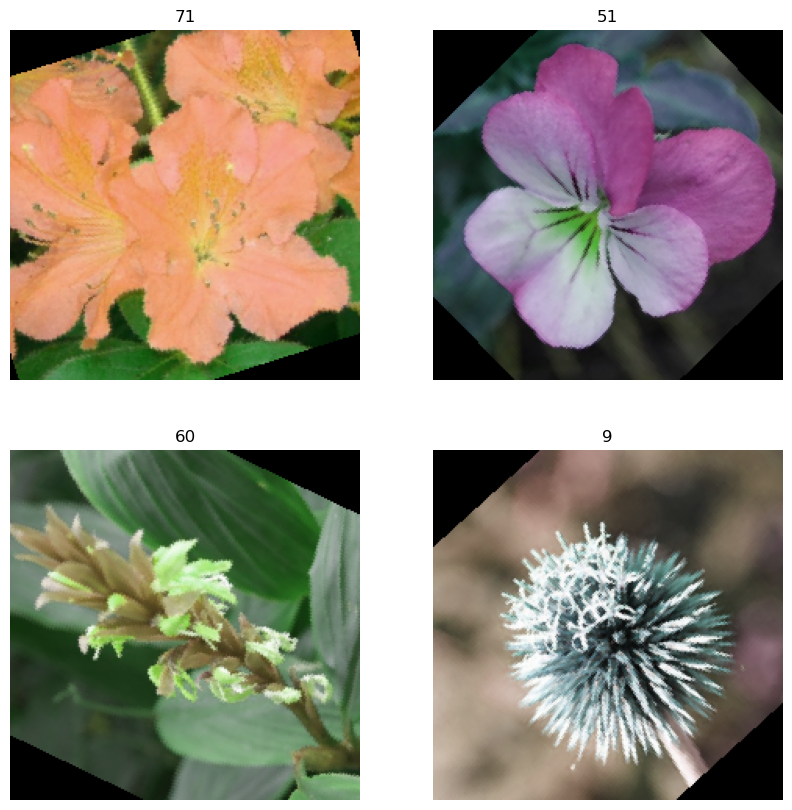

In [62]:
#Checking the training transformations are ok
figure = plt.figure(figsize=(10,10))
col, row = 2, 2
for i in range(1, 5): #TODO: Change this to be rows * columns
  randImg = torch.randint(len(trainingSet), size=(1,)).item() #Size defines the shape of the tensor
  img, label = trainingSet[randImg]
  figure.add_subplot(row, col, i)
  plt.title(label)
  plt.axis(False)
  plt.imshow(img.squeeze().permute(1,2,0)) #Permute gets the dimentions in the correct order
plt.show()

In [3]:
#Checking if collab can connect to a GPU
if torch.cuda.is_available():
  device = torch.device('cuda:0')
else:
  device = torch.device('cpu')
print(device)


cuda:0


In [4]:
#The CNN itself
class CNN(nn.Module):
  def __init__(self):
    super().__init__()
    #DEFINING THE LAYERS. THIS IS WHERE WE WILL SPEND MOST OF OUR TIME
    self.netLayers = nn.Sequential(
        # block 1 (<- considering how to talk abt layers in method don't mind me)
        nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, padding=1),
        nn.BatchNorm2d(64),
        nn.MaxPool2d(2,2),

        #block 2
        nn.ReLU(),
        nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=(1,1), padding=1),
        nn.ReLU(),
        nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, stride=(1,1), padding=1),
        nn.ReLU(),
        nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=(1,1), padding=1),
        nn.ReLU(),
        nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, stride=(1,1), padding=1),
        
        #block 3
        nn.AvgPool2d(2,2),
        nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, stride=(1,1), padding=1),
        nn.BatchNorm2d(256),
        
        #block 4
        nn.ReLU(),
        nn.MaxPool2d(2,2),
        nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, stride=(1,1), padding=1),
        
        # block 5
        nn.BatchNorm2d(512),
        nn.ReLU(),
        nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, stride=(1,1), padding=1),
        nn.BatchNorm2d(512),
        nn.ReLU(),
        nn.MaxPool2d(2,2),
        nn.Flatten(),
        #IMPORTANT: in channels for first linear must be
        # (image size) * (image size) * C
        #Where C is the out channels of the last conv2d
        #If confused, just print out the shape of the matrix

        # fully connected layer
        nn.Linear(100352, 1020),
        nn.BatchNorm1d(1020),
        nn.ReLU(),
        nn.Dropout(0.5),

        nn.Linear(1020, 1020),
        nn.BatchNorm1d(1020),
        nn.LeakyReLU(), #Prevents 'Dead ReLU' issues
        nn.Dropout(0.5),

        nn.Linear(1020, 256),
        nn.BatchNorm1d(256),
        nn.ReLU(),
        nn.Dropout(0.2),

        nn.Linear(256, 102), #102 for the classifiers
        #nn.LogSoftmax(dim=1)
    )
  
  def forward(self, x):
      result = self.netLayers(x)
      #print(result.shape)
      return result
  

print(CNN())


CNN(
  (netLayers): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): ReLU()
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): ReLU()
    (6): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU()
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (14): ReLU()
    (15): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (16): Conv2d(256, 

In [ ]:
#TODO: Code to train the CNN on the training set for a set amount of minutes.
def timedTrain(minutes, cnn, lossFunction, optimiser, showGraph):
  startTime = time.time()
  endTime = time.time() + (minutes * 60)
  trainingError = []


In [5]:
#Code to train the CNN based on a set number of epochs
def epochCountTrain(trainLoader, cnn, optimizer, lossFunction):
  totalLoss, correct = 0, 0
  size = len(trainLoader.dataset)
  for i, data in enumerate(trainLoader, 0):
    input, labels = data
    input = input.to(device)
    labels = labels.to(device)
    optimizer.zero_grad()
    output = cnn(input)
    loss = lossFunction(output, labels)
    loss.backward()
    optimizer.step()
    totalLoss += loss.item()
    correct += (output.argmax(1)==labels).sum().item()
    if i % 20 == 0:
      loss, currentLoss = loss.item(), (i + 1) * len(input)
      print(f"loss: {loss:>7f}    [{currentLoss:>5d}/{size:>5d}]")
      
  epochTrainLoss.append(float(loss))
  epochTrainAccuracy.append(round((correct/size)*100, 1))
  print(f"\nAvg train loss: {(totalLoss/len(trainLoader)):>8f}")
  print(f"Train accuracy = {((correct/size) * 100): >0.1f}%")

In [6]:
#Code to guess accuracy based on validation set
def validation(valLoader, cnn, lossFunction):
  valSize = len(valLoader.dataset)
  correct = 0
  loss = []
  with torch.no_grad(): #as we are not calling backward, use no grad to save memory
    for batch in valLoader:
      input, labels = batch
      input = input.to(device)
      labels = labels.to(device)
      prediciton = cnn(input)
      loss.append(lossFunction(prediciton, labels).item())
      correct += (prediciton.argmax(1) == labels).sum().item()
  
  epochValLoss.append((np.average(loss)))
  epochValAccuracy.append(round((correct/valSize)*100, 1))
  print(f"Accuracy on validation set = {((correct / valSize) * 100):>0.1f}%")
  print(f"Average loss on validation set = {(np.average(loss))}\n")




In [7]:
#Code that gets the accuracy of the test set!
def test(testLoader, cnn):
  testSize = len(testLoader.dataset)
  correct = 0
  with torch.no_grad():
    for batch in testLoader:
      input, labels = batch
      input = input.to(device)
      labels = labels.to(device)
      prediciton = cnn(input)
      correct +=(prediciton.argmax(1) == labels).sum().item()
  print("----------------------------------------------------")    
  print(f"Accuracy on test set = {((correct / testSize) * 100):>0.1f}%")
  print("----------------------------------------------------")  

In [11]:
#Instantiate the model, loss function and optimiser, done to prevent resets when rerunning the code below
epochCount = 100
learningRate = 0.00005
batchSize = 32
lossFunction = nn.CrossEntropyLoss()
model = CNN().to(device)
optimizer = AdamW(lr=learningRate, params=model.parameters(), weight_decay=0.1)
trainDataloader = DataLoader(trainingSet, batch_size=batchSize, shuffle=True)
valDataloader = DataLoader(validationSet, batch_size=batchSize, shuffle=True)
testDataloader = DataLoader(testingSet, batch_size=batchSize, shuffle=True)

epochTrainLoss = []
epochTrainAccuracy = []

epochValLoss = []
epochValAccuracy = []

epochCountList = []

In [12]:
#Actual code to get it all running
for i in range(epochCount):
  print(f"Epoch {i+1}")
  model.train()
  epochCountTrain(trainDataloader, model, optimizer, lossFunction)
  model.eval()
  validation(valDataloader, model, lossFunction)
  epochCountList.append(i+1)

Epoch 1
loss: 4.689925    [   32/ 2040]
loss: 4.685727    [  672/ 2040]
loss: 4.703444    [ 1312/ 2040]
loss: 4.620834    [ 1952/ 2040]

Avg train loss: 4.624685
Train accuracy = 2.0%
Accuracy on validation set = 3.7%
Average loss on validation set = 4.5750885009765625

Epoch 2
loss: 4.521146    [   32/ 2040]
loss: 4.540401    [  672/ 2040]
loss: 4.334126    [ 1312/ 2040]
loss: 4.379129    [ 1952/ 2040]

Avg train loss: 4.430351
Train accuracy = 5.1%
Accuracy on validation set = 9.2%
Average loss on validation set = 4.299334213137627

Epoch 3
loss: 4.213603    [   32/ 2040]
loss: 4.442033    [  672/ 2040]
loss: 4.273225    [ 1312/ 2040]
loss: 4.324409    [ 1952/ 2040]

Avg train loss: 4.285975
Train accuracy = 7.9%
Accuracy on validation set = 12.9%
Average loss on validation set = 4.187555253505707

Epoch 4
loss: 4.187507    [   32/ 2040]
loss: 4.411901    [  672/ 2040]
loss: 4.176226    [ 1312/ 2040]
loss: 4.202106    [ 1952/ 2040]

Avg train loss: 4.187265
Train accuracy = 9.1%
Accu

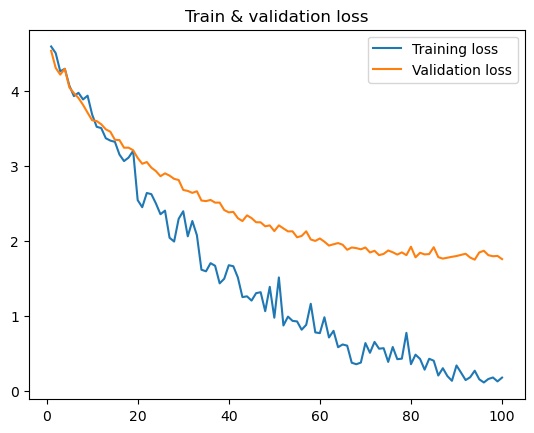

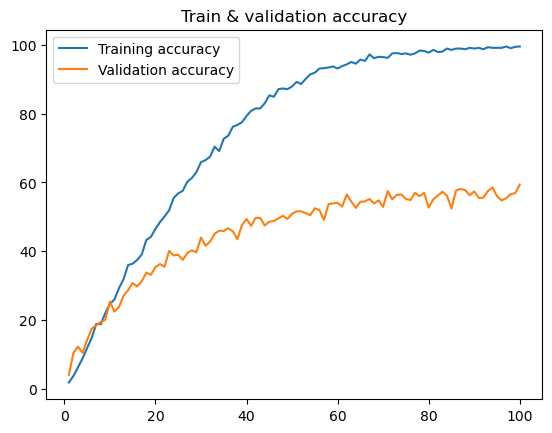

In [83]:
#plot the loss and accuracy of the training and validation set
plt.plot(epochCountList, epochTrainLoss, label="Training loss")
plt.plot(epochCountList, epochValLoss, label="Validation loss")
plt.title("Train & validation loss")
plt.legend()
plt.show()

plt.plot(epochCountList, epochTrainAccuracy, label="Training accuracy")
plt.plot(epochCountList, epochValAccuracy, label="Validation accuracy")
plt.title("Train & validation accuracy")
plt.legend()
plt.show()

In [ ]:
#Save the model to the drive
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [85]:
PATH ="./53PercentTestAccuracy.pth"
torch.save(model.state_dict(), PATH)

In [13]:
#Run the model on the test set
test(testDataloader, model)

----------------------------------------------------
Accuracy on test set = 49.8%
----------------------------------------------------
